In [1]:
import pandas as pd
import env
import utilities as utils
import numpy as np

import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [3]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.shape

(7613, 4)

In [5]:
train.keyword.value_counts(dropna=False)

NaN                      61
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

## Clean up keyword series

In [6]:
train.keyword = train.keyword.str.replace('%20', '_').str.lower().str.strip()

In [7]:
train.keyword.value_counts(dropna=False)

NaN                    61
fatalities             45
armageddon             42
deluge                 42
damage                 41
                       ..
forest_fire            19
epicentre              12
threat                 11
inundation             10
radiation_emergency     9
Name: keyword, Length: 222, dtype: int64

## Clean up location

In [8]:
train.location = train.location.str.lower().str.strip()

In [9]:
train.location.value_counts()

usa                               105
new york                           77
united states                      50
london                             50
nigeria                            35
                                 ... 
world wide!!                        1
#1 vacation destination,hawaii      1
bangkok thailand                    1
annapolis, md                       1
                                    1
Name: location, Length: 3164, dtype: int64

### Explore a bit before doing this ^^

## Clean up Text

In [10]:
import prepare as prep

In [11]:
train['text_cleaned'] = ([prep.clean_lem_stop(string) for string in train.text])

In [12]:
train.text_cleaned.head()

id
1           deed reason earthquake may allah forgive u
4                forest fire near la ronge sask canada
5    resident asked ' shelter place ' notified offi...
6    13000 people receive wildfire evacuation order...
7    got sent photo ruby alaska smoke wildfire pour...
Name: text_cleaned, dtype: object

In [13]:
train[train.text_cleaned.isnull()]

,keyword,location,text,target,text_cleaned
id,,,,,


In [14]:
train.isnull().sum()

keyword           61
location        2533
text               0
target             0
text_cleaned       0
dtype: int64

### Create visualisations for exploration

In [15]:
disaster_text = ' '.join(train[train.target == 1].text)
no_disaster_text = ' '.join(train[train.target == 0].text)

In [16]:
import explore as ex
from wordcloud import WordCloud

In [17]:
ex.counts_and_ratios(train, 'text_cleaned')

,n,pct
11yearold boy charged manslaughter toddler report 11yearold boy ha charged manslaughter fatal sh,10,0.001314
horrible sinking feeling youuave home phone realise 3g whole time,7,0.000919
bestnaijamade 16yr old pkk suicide bomber detonated bomb httptcoksawlyux02 bestnaijamade bestnaijamade bestnaijamade beu,6,0.000788
came land wa engulfed tribal war turned land peace ie madinah prophetmuhammad islam,6,0.000788
prophet peace upon said ' save hellfire even giving half date charity ',6,0.000788
...,...,...
watch sarah palin obliterate planned parenthood targeting minority woman uo bb4sp httptcodm0uupqgwy,1,0.000131
' make fun trying survive racist elitist country,1,0.000131
' may gotten little exited home made lava lamp ' httptco724gq5ebqz httptcoh01j9pirie,1,0.000131
last day summer supposed fun ' fun accidentally burning arm hair playing w lighter,1,0.000131


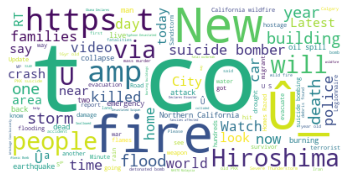

In [18]:
ex.create_wordcloud(disaster_text)

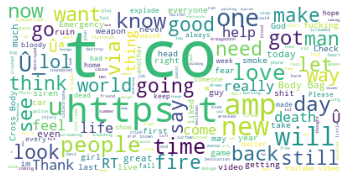

In [19]:
ex.create_wordcloud(no_disaster_text)

In [20]:
extra_words = ['t','co', 'https', 'people']
disaster_text = prep.remove_stopwords(disaster_text, more_stopwords=extra_words)
no_disaster_text = prep.remove_stopwords(no_disaster_text, more_stopwords=extra_words)

In [21]:
bigrams = nltk.ngrams(disaster_text.split(), 2)
trigrams = nltk.ngrams(disaster_text.split(), 3)

In [22]:
top_20_dis_bigrams = (pd.Series(bigrams).value_counts().head(20))
top_20_dis_bigrams

(suicide, bomber)         38
(Northern, California)    36
(bomber, detonated)       30
(The, Latest:)            30
(Latest:, More)           28
(detonated, bomb)         28
(PKK, suicide)            28
(16yr, old)               28
(oil, spill)              28
(old, PKK)                27
(40, families)            26
(More, 40)                26
(suicide, bombing)        26
(fatal, outbreak)         26
(Families, sue)           26
(families, affected)      26
(affected, fatal)         26
(sue, Legionnaires:)      25
(Legionnaires:, More)     25
(A, Sandstorm)            24
dtype: int64

In [23]:
top_20_dis_trigrams = (pd.Series(trigrams).value_counts().head(20))
top_20_dis_trigrams

(suicide, bomber, detonated)      30
(PKK, suicide, bomber)            28
(bomber, detonated, bomb)         28
(The, Latest:, More)              28
(old, PKK, suicide)               27
(16yr, old, PKK)                  27
(affected, fatal, outbreak)       26
(40, families, affected)          26
(families, affected, fatal)       26
(More, 40, families)              26
(sue, Legionnaires:, More)        25
(Families, sue, Legionnaires:)    25
(Legionnaires:, More, 40)         25
(Get, Swallowed, Up)              24
(Up, By, A)                       24
(This, Airport, Get)              24
(Under, A, Minute)                24
(Swallowed, Up, By)               24
(Sandstorm, In, Under)            24
(Watch, This, Airport)            24
dtype: int64

In [25]:
ex.compare_word_counts(df=train, text_col='text', cat_col='target', group1=1, group2=0)

(              all       1       0
 '          3156.0  1094.0  2063.0
 0            12.0     9.0     3.0
 0011          1.0     1.0     0.0
 001116        2.0     2.0     0.0
 0025          1.0     0.0     1.0
 ...           ...     ...     ...
 zrnf          1.0     0.0     1.0
 zumiez        1.0     0.0     1.0
 zurich        1.0     1.0     0.0
 zxathetis     1.0     0.0     1.0
 zzzz          1.0     0.0     1.0
 
 [21172 rows x 3 columns],
                    all    1    0
 hoodedu            1.0  0.0  1.0
 hoof               1.0  0.0  1.0
 hop                4.0  0.0  4.0
 hoped              1.0  0.0  1.0
 hond               1.0  0.0  1.0
 zzzz               1.0  0.0  1.0
 httptco3ac5wuy1r0  1.0  1.0  0.0
 httptco3a3fgzfmzh  1.0  1.0  0.0
 httptco39iabcc5pk  1.0  1.0  0.0
 httptco37dqvjhncv  1.0  1.0  0.0
 httptco3huhzxliig  1.0  1.0  0.0
 zurich             1.0  1.0  0.0)

In [ ]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_sport=word_counts.sports / word_counts['all'],
         p_pol=word_counts.politics / word_counts['all'])
 .sort_values(by='all')
 [['p_sport', 'p_pol']]
 .tail(20)
 .sort_values('p_pol')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')